In [2]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline

np.seterr(under = 'ignore')

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

# Infinite Temperature Limit

This notebook explores the infinite temperature limit.

In [5]:
from FKMC.general import interaction_matrix, solve_H_vectorised, shapes
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index
from FKMC.plotting import spread

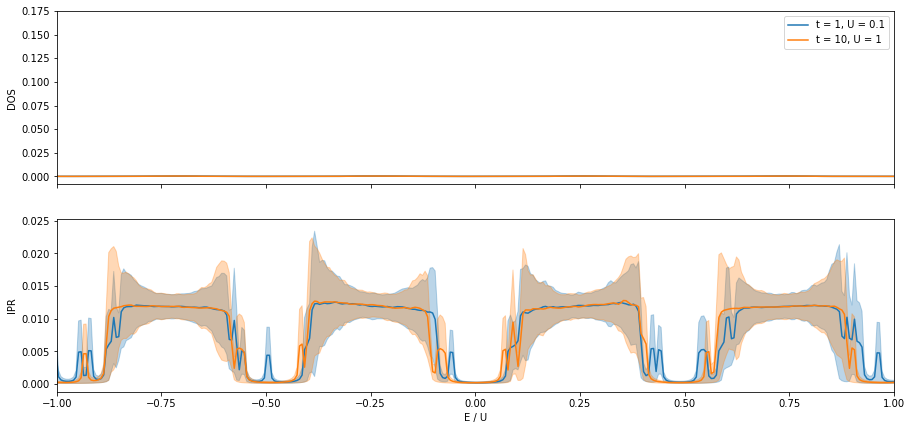

In [6]:
def solve(states, params, energy_histogram_bins, scale = 1):
    params.J_matrix = interaction_matrix(**params)

    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **params)

    #calculate the IPR measure
    IPR_raw_values = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

    #take lists of IPR and eigenvalues and bin them into histograms
    DOS, _, sorting_indices = index_histogram_array(energy_histogram_bins, eigenvals)
    IPR = sort_IPRs(sorting_indices, IPR_raw_values, energy_histogram_bins)

    DOS, dDOS = DOS.mean(axis = 0), scipy.stats.sem(DOS, axis = 0)
    IPR, dIPR = IPR.mean(axis = 0), scipy.stats.sem(IPR, axis = 0)

    #divide IPR by DOS without incurring divide by errors where DOS = 0, set IPR = 0 there too
    DOS, IPR = normalise_IPR(DOS, IPR)
    _, dIPR = normalise_IPR(DOS, dIPR)

    #smooth out the spikey IPR values
    DOS = smooth(DOS, scale = scale, axis = -1) / N
    IPR = smooth(IPR, scale = scale, axis = -1)
    
    dDOS = smooth(dDOS, scale = scale, axis = -1) / N
    dIPR = smooth(dIPR, scale = scale, axis = -1)
    
    return DOS, IPR, dDOS, dIPR

M = int(1000) # average over this many replications
N = 128 # system size


f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')
for t, U in [[1,0.1], [10,1]]:
    states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    params = Munch(mu=0.0, beta = np.nan, U = U, t = t, N = N, alpha = 1.25, J = 1.0)
    energy_histogram_bins = np.linspace(-3*U, 3*U, 1000 + 1)
    
    #alternating = 2*(np.arange(N) % 2) - 1
    #alternating_power_law_noise = power_law_noise * alternating

    DOS, IPR, dDOS, dIPR = solve(states, params, energy_histogram_bins, scale = 10 / N)

    #dl, = axes[0].plot(energy_histogram_bins[1:] / U, DOS, label = f't = {t}, U = {U}')
    #il, = axes[1].plot(energy_histogram_bins[1:] / U, IPR)
    spread(axes[0], energy_histogram_bins[1:] / U, DOS, dDOS, label = f't = {t}, U = {U}')
    spread(axes[1], energy_histogram_bins[1:] / U, IPR, dIPR)

    
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlim = (-1,1), xlabel = 'E / U')
axes[0].legend();

The above I am: 
1) generating unbiased, uncorrelated strings of 0s and 1s giving of U_i = U * ([0,1,1,0,0,0,0,1,1,0] - 1/2)
2) using that to repeatedly solve the tridiagonal hamiltonian with U_i on it's diagonal and -t on the two off diagonals.
   The eigenvalues returns from this procedure are immediatly returned, I checked the code and there is no addition of the classical energy at all. 
3) The eigenvectors and eigenvalues are used to calculate DOSs and IPRs.

I'm stripping it back to the basics and doing a really simple check: Does t = 1 U = 10 give the same results as t = 0.1, U = 1 and the above plot suggests it does.

# IPR Scaling with system size at $T = \infty$

Ok with the next plot I'll look at scaling of the IPR with system size, we expect to see everything looking localised.

In [29]:
N_eigenstates = 50000 # do states / N disorder realisations
infT_Ns = [32, 64, 128, 256, 512, 1024]# system sizes

t = 1
U = 5
spread_IPR = False

energy_histogram_bins = np.linspace(-3*U, 3*U, 1000 + 1)
infT_DOS = np.nan * np.zeros(shape = (len(infT_Ns), len(energy_histogram_bins)-1))
infT_IPR = np.nan * np.zeros(shape = (len(infT_Ns), len(energy_histogram_bins)-1))
infT_dDOS = np.nan * np.zeros(shape = (len(infT_Ns), len(energy_histogram_bins)-1))
infT_dIPR = np.nan * np.zeros(shape = (len(infT_Ns), len(energy_histogram_bins)-1))

for i,N in zip(count(), infT_Ns):
    M = N_eigenstates // N + 1 # Number of Disorder_realisations
    states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    params = Munch(mu=0.0, beta = np.nan, U = U, t = t, N = N, alpha = 1.25, J = 1.0)
    infT_DOS[i], infT_IPR[i], infT_dDOS[i], infT_dIPR[i] = solve(states, params, scale = 0.5, energy_histogram_bins = energy_histogram_bins)

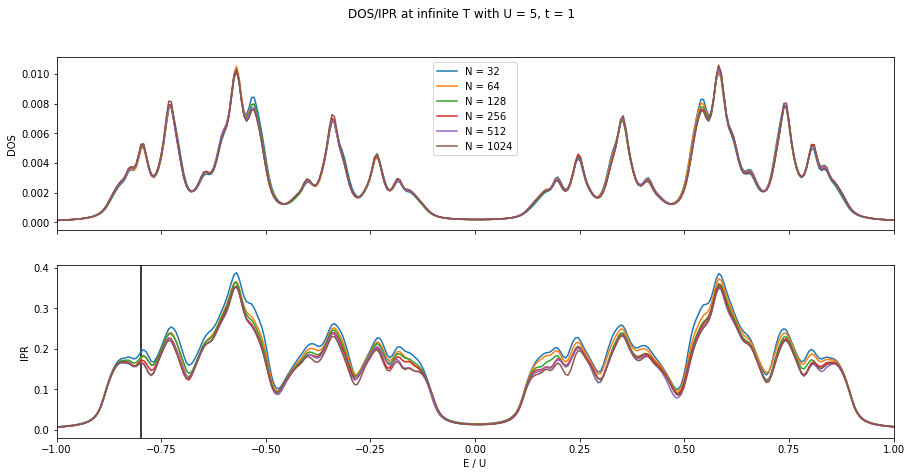

In [30]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')

for i,N in zip(count(), infT_Ns):
    axes[0].plot(energy_histogram_bins[1:] / U, infT_DOS[i], label = f'N = {N}', color = colors[i])
    if spread_IPR:
        spread(axes[1], energy_histogram_bins[1:] / U, IPR[i], dIPR[i], color = colors[i])
    else:    
        axes[1].plot(energy_histogram_bins[1:] / U, infT_IPR[i], color = colors[i])

E, E_i = get_nearby_index(energy_histogram_bins, -4)
curr_ylim = axes[1].get_ylim()
axes[1].vlines([E/U,], *curr_ylim)
axes[1].set(ylim = curr_ylim)


f.suptitle(f'DOS/IPR at infinite T with U = {U}, t = {t}')
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlim = (-1,1), xlabel = 'E / U')
axes[0].legend();

The above looks as I'd expect! I'll plot the scaling of IPR with system size for a particular energy now.

IPR = exp(c) * N ** m
params: m = -0.05 +- 0.05, c = -1.50 +- 0.24


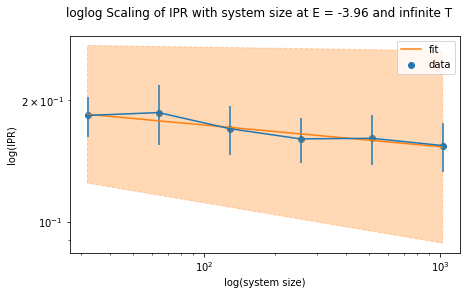

In [6]:
IPR_at_E = infT_IPR[:, E_i]
dIPR_at_E = infT_dIPR[:, E_i] 

Y = np.log(IPR_at_E)
dY = dIPR_at_E / IPR_at_E
X = np.log(infT_Ns)

f, ax = plt.subplots(figsize = (7,4))

ax.scatter(infT_Ns, IPR_at_E, label = 'data')
ax.errorbar(infT_Ns, IPR_at_E, dIPR_at_E, linestyle = None)
ax.set(xlabel = 'log(system size)', ylabel = f'log(IPR)', yscale = 'log', xscale = 'log')

f.suptitle(f'loglog Scaling of IPR with system size at E = {E:.2f} and infinite T');

if np.any(dY > 0):
    (m, c), cov = np.polyfit(X, Y, deg = 1, cov='unscaled', w = 1 / dY)
else:
    (m, c), cov = np.polyfit(X, Y, deg = 1, cov=True)
    
dm, dc = np.sqrt(np.diag(cov))


fineX = np.linspace(min(X), max(X), 100)
l, = ax.plot(np.exp(fineX), np.exp(m*fineX + c), label = 'fit', linestyle = '-')
ax.fill_between(np.exp(fineX), np.exp((m+dm)*fineX + (c+dc)), np.exp((m-dm)*fineX + (c-dc)),
                linestyle = '--', color = l.get_color(), alpha = 0.3)

ax.legend();
# IPR = A * N ** (-d)
# ln IPR = -d ln N + ln A = m ln N + c
# IPR = e**c * N ** (-m)

print('IPR = exp(c) * N ** m')
print(f'params: m = {m:.2f} +- {dm:.2f}, c = {c:.2f} +- {dc:.2f}')

Now applying that same code to make an estimate of the scaling dimension of IPR for every point on the spectrum

In [4]:
def scaling_dimension(Ns, IPR, dIPR, use_true_errors = True):
    Y = np.log(IPR)
    dY = np.max(dIPR / IPR, axis = -1) #take the maximum error across the energy spectrum because we can't do it individually
    X = np.log(Ns)

    if use_true_errors:
        (m, c), cov = np.polyfit(X, Y, deg = 1, cov=True, w = 1 / dY)
    else:
        (m, c), cov = np.polyfit(X, Y, deg = 1, cov=True)
    dm, dc = np.sqrt(np.einsum('iik -> ik', cov))
    
    return m, c, dm, dc


infT_m, infT_c, infT_dm, infT_dc = scaling_dimension(infT_Ns, infT_IPR, infT_dIPR)
                 
f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')

for i,N in zip(count(), infT_Ns):   
    axes[0].plot(energy_histogram_bins[1:] / U, infT_IPR[i], color = colors[i])
    spread(axes[1], energy_histogram_bins[1:] / U, -infT_m, infT_dm, color = colors[i])


f.suptitle(f'IPR and Scaling Dimension of IPR at infinite T with U = {U}, t = {t}')
axes[0].set(ylabel = 'IPR')    
axes[1].set(ylabel = 'Scaling dimension of IPR', xlim = (-1,1), xlabel = 'E / U')
axes[0].legend();

NameError: name 'infT_Ns' is not defined

The above seems to work fine, the calculated scaling dimensions are very close to zero which extended states should be closer to one. Next I'll check the same thing for a clean system and a real one.

## IPR scaling dimension for a T = 0 system with AFM disorder that has all extended states

In [8]:
Ns = [32, 64, 128, 256, 512, 1024]# system sizes
t = 1
U = 10

energy_histogram_bins = np.linspace(-3*U, 3*U, 1000 + 1)
DOS = np.nan * np.zeros(shape = (len(Ns), len(energy_histogram_bins)-1))
IPR = np.nan * np.zeros(shape = (len(Ns), len(energy_histogram_bins)-1))
dDOS = np.nan * np.zeros(shape = (len(Ns), len(energy_histogram_bins)-1))
dIPR =np.nan * np.zeros(shape = (len(Ns), len(energy_histogram_bins)-1))

for i,N in zip(count(), Ns):
    states = (np.arange(N) % 2)[None, :] * 1
    #alternating_power_law_noise = power_law_noise * alternating
    params = Munch(mu=0.0, beta = np.nan, U = U, t = t, N = N, alpha = 1.25, J = 1.0)
    DOS[i], IPR[i], dDOS[i], dIPR[i] = solve(states, params, scale = 0.01, energy_histogram_bins = energy_histogram_bins)

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [9]:

use_true_errors = False

Y = np.log(IPR)
dY = np.max(dIPR / IPR, axis = -1) #take the maximum error across the energy spectrum because we can't do it individually
X = np.log(Ns)

if use_true_errors:
    (m, c), cov = np.polyfit(X, Y, deg = 1, cov=True, w = 1 / dY)
else:
    (m, c), cov = np.polyfit(X, Y, deg = 1, cov=True)

dm, dc = np.sqrt(np.einsum('iik -> ik', cov))

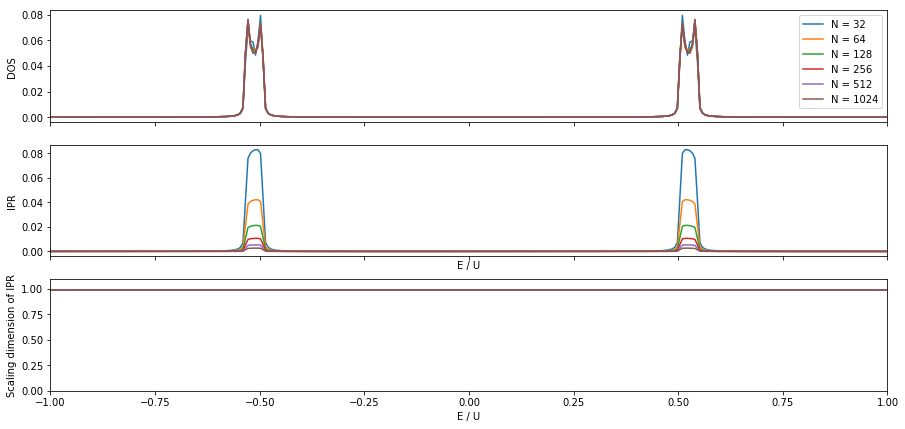

In [10]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
f, axes = plt.subplots(3,1, figsize = (15,7), sharex = 'col')

for i,N in zip(count(), Ns):
    axes[0].plot(energy_histogram_bins[1:] / U, DOS[i], label = f'N = {N}', color = colors[i])
    if spread_IPR:
        spread(axes[1], energy_histogram_bins[1:] / U, IPR[i], dIPR[i], color = colors[i])
    else:    
        axes[1].plot(energy_histogram_bins[1:] / U, IPR[i], color = colors[i])

    spread(axes[2], energy_histogram_bins[1:] / U, -m, dm, color = colors[i])


axes[2].set(ylabel = 'Scaling dimension of IPR', xlim = (-1,1), xlabel = 'E / U', ylim = (0, 1.1))
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlim = (-1,1), xlabel = 'E / U')
axes[0].legend();

## Change with U at infinite T

In [263]:
o = oUsweep = Munch()
o.M = int(10) # average over this many replications
o.N = 128 # system size
o.Us = np.linspace(0.1, 10, 100)
o.t = 1
o.energy_bins = 1000



o.E_bins = np.linspace(-2*max(o.Us), 2*max(o.Us), energy_bins + 1)
o.DOS, o.IPR, o.dDOS, o.dIPR = np.empty(shape = (4, len(o.Us), energy_bins))


for i, U in zip(count(), o.Us):
    states = np.random.choice([1,0], size = (o.M,o.N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    o.params = Munch(mu=0.0, beta = np.nan, U = U, t = o.t, N = o.N, alpha = 1.25, J = 1.0)
    
    #alternating = 2*(np.arange(N) % 2) - 1
    #alternating_power_law_noise = power_law_noise * alternating

    o.DOS[i], o.IPR[i], o.dDOS[i], o.dIPR[i] = solve(states, o.params, o.E_bins, scale = 128 / o.N)

In [274]:
o.DOS.shape

(100, 1000)

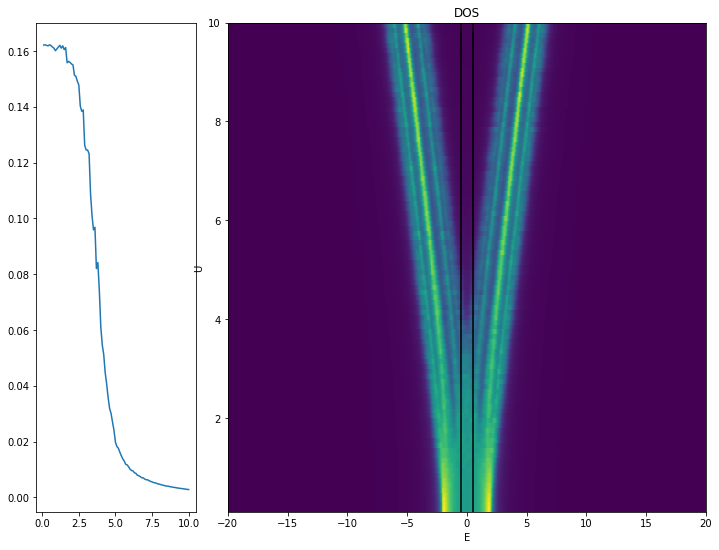

In [277]:
from matplotlib import colors

o = oUsweep
f, axes = plt.subplots(1,2, figsize = (12,9), 
                       gridspec_kw = dict(width_ratios = (1,3), wspace = 0.1),
                      )

norm = colors.Normalize(vmin=-1, vmax=1)

axes[1].set(title = f'DOS', ylabel = 'U', xlabel = 'E')

axes[1].pcolormesh(o.E_bins, o.Us, o.DOS, cmap='viridis')

e_bin = 0.5
ylim = axes[1].get_ylim()
axes[1].vlines([-e_bin, e_bin], ymin = ylim[0], ymax= ylim[1])
axes[1].set(ylim = ylim)

mask = (-e_bin < o.E_bins[:-1]) & (o.E_bins[:-1] < e_bin)
sums = o.DOS[:, mask].sum(axis = -1)
axes[0].plot(o.Us, sums)

In [ ]:
o = oUsweep2 = Munch()
o.M = int(50) # average over this many replications
o.N = 128 # system size
o.Us = np.linspace(0, 100, 100)
o.t = 1
o.energy_bins = 1000



o.E_bins = np.linspace(-2, 2, energy_bins + 1)
o.DOS, o.IPR, o.dDOS, o.dIPR = np.empty(shape = (4, len(o.Us), energy_bins))


for i, U in zip(count(), o.Us):
    states = np.random.choice([1,0], size = (o.M,o.N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    o.params = Munch(mu=0.0, beta = np.nan, U = U, t = o.t, N = o.N, alpha = 1.25, J = 1.0)
    
    #alternating = 2*(np.arange(N) % 2) - 1
    #alternating_power_law_noise = power_law_noise * alternating

    o.DOS[i], o.IPR[i], o.dDOS[i], o.dIPR[i] = solve(states, o.params, o.E_bins * U, scale = 10 / o.N)

## Trying it on some real data

In [279]:
#%%time
from munch import munchify
#this data has was preprocessed and saved in munich/Figures/Data_preparation_for_linear_T_plots.ipynb
#gatherered using get_data_funcmap so IPR is normalised by DOS
with open('/workspace/tch14/pickled_data/Long_range_linear_T_sweep_IPR_DOS_and_errors.pickle', 'rb') as file: 
    oLR = munchify(pickle.load(file))
    
print(f"Keys available in long range data: {oLR.keys()}")

print("Hamiltionian params for the Long Range data:")
oLR.parameters.beta = "Variable"
print(", ".join(f"{k} = {v}" for k,v in oLR.parameters.items()))
print('\n')

print("Simulation params for the Long Range data:")
print(oLR.MCMC_params)

print('\nShape hint for oLR.IPR')
print(oLR.hints.DOS)
print(oLR.DOS.shape)
    
o = oLR
o.energy_histogram_bins = o.E_bins

Nmask = (o.Ns > 8)
for name in ['DOS', 'dDOS', 'IPR', 'dIPR', 'Ns']:
    o[name] = o[name][Nmask]

#('Ns', 'Ts', 'repeats', 'initial_state', 'energy index')
axis = (2,3) #mean out the repeat and starting states axes
from scipy.stats import sem

#use the indepedant repeats to estimate the errors
o.DOS, o.dDOS = o.DOS.mean(axis = axis), sem(o.DOS.mean(axis = 3), axis = 2)
o.IPR, o.dIPR = o.IPR.mean(axis = axis), sem(o.IPR.mean(axis = 3), axis = 2)

#use binning over the mcmc steps to estimate the errors
#o.DOS, o.dDOS = o.DOS.mean(axis = axis), o.dDOS.mean(axis = axis)
#o.IPR, o.dIPR = o.IPR.mean(axis = axis), o.dIPR.mean(axis = axis)

#('Ns', 'Ts', 'energy index')

#smooth them
print(o.Ns)
for i, N in zip(count(), o.Ns):
    o.DOS[i] = smooth(o.DOS[i], scale = 32 / N) / N
    o.IPR[i] = smooth(o.IPR[i], scale = 32 / N)

    o.dDOS[i] = smooth(o.dDOS[i], scale = 32 / N) / N
    o.dIPR[i] = smooth(o.dIPR[i], scale = 32 / N)
    
print('Loaded data for Long Range IPR and DOS as a function of T')

Keys available in long range data: dict_keys(['Ns', 'parameters', 'MCMC_params', 'desc', 'structure_names', 'structure_dims', 'hints', 'E_bins', 'Ts', 'DOS', 'IPR', 'dIPR', 'dDOS', 'Mf_moments'])
Hamiltionian params for the Long Range data:
t = 1, alpha = 1.25, mu = 0, beta = Variable, J = 5, U = 1, normalise = True, J_matrix = ...


Simulation params for the Long Range data:
Munch({'state': '...', 'N_steps': 100000, 'N_burn_in': 1000, 'thin': 1000, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f407e3f2cc0>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f4089c15620>, 'accept_function': <function perturbation_accept at 0x7f4089c15950>, 'warnings': True})

Shape hint for oLR.IPR
('Ns', 'Ts', 'repeats', 'initial_state', 'energy index')
(6, 200, 10, 4, 2000)
[ 16  32  64 128]
Loaded data for Long Range IPR and DOS as a function of T


T = 4.0, T_i = 199
(4, 2000), (4,)


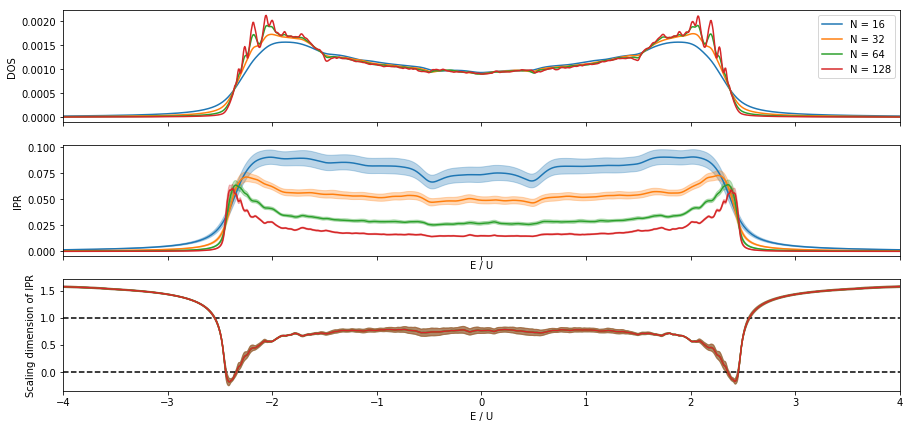

In [280]:
spread_IPR = True

T, T_i = get_nearby_index(o.Ts, 4)
print(f'T = {T}, T_i = {T_i}')

shapes(o.IPR[:, T_i], o.Ns)
m, c, dm, dc = scaling_dimension(o.Ns, o.IPR[:, T_i], o.dIPR[:, T_i], use_true_errors = True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
f, axes = plt.subplots(3,1, figsize = (15,7), sharex = 'col')

for i,N in zip(count(), o.Ns):
    axes[0].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.DOS[i, T_i], label = f'N = {N}', color = colors[i])
    if spread_IPR:
        spread(axes[1], o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], o.dIPR[i, T_i], color = colors[i])
    else:    
        axes[1].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], color = colors[i])

    spread(axes[2], o.energy_histogram_bins[1:] / o.parameters.U, -m, dm, color = colors[i])


axes[2].set(ylabel = 'Scaling dimension of IPR', xlim = (-1,1), xlabel = 'E / U')

axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlim = (-4,4), xlabel = 'E / U')

xlim = axes[2].get_xlim()
axes[2].hlines([0,1], xmin = xlim[0], xmax = xlim[1], linestyles = 'dashed')

axes[0].legend();

In [141]:
o.m, o.dm = np.nan * np.zeros(shape = (2, len(o.Ts), len(o.E_bins)-1))
for i, T in zip(count(), o.Ts):
    o.m[i], _, o.dm[i], _ = scaling_dimension(o.Ns, o.IPR[:, i], o.dIPR[:, i], use_true_errors = True)

In [145]:
o.hints.Mf_moments, o.Mf_moments.shape

(('Ns', 'Ts', 'repeats', 'initial_state', 'MCstep'), (6, 200, 10, 4, 5))

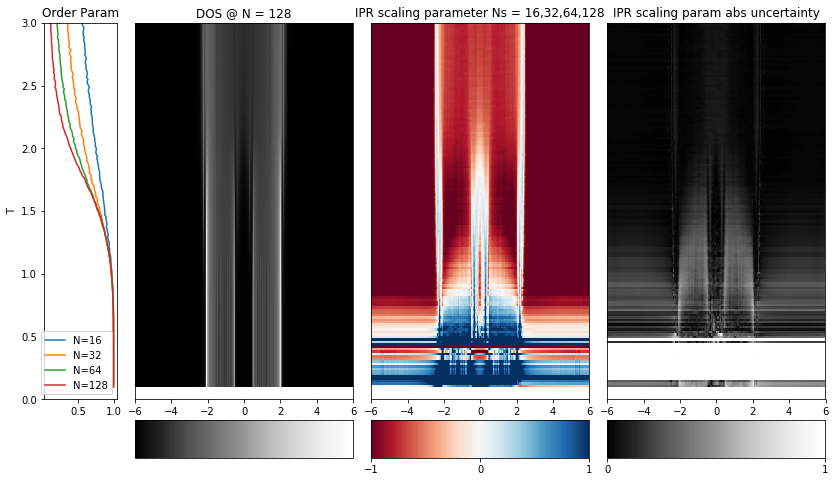

In [195]:
from matplotlib import colors
f, (axes,cbars) = plt.subplots(2,4, figsize = (14,8), 
                       gridspec_kw = dict(width_ratios = (1,3,3,3),
                                          height_ratios = (10,1),
                                          wspace = 0.1,
                                           hspace = 0.1),
                      )


axes[0].set(title = 'Order Param', ylabel = 'T')
msquared = o.Mf_moments[..., 2].mean(axis = (2,3))
for i,N in zip(count(), o.Ns): axes[0].plot(msquared[i], o.Ts, label = f'N={N}')
axes[0].legend()

axes[1].set(title = f'DOS @ N = {max(o.Ns)}', xlabel = 'E', ylim = (0, 3))
cs = axes[1].pcolormesh(o.E_bins[:-1], o.Ts, o.DOS[-1], cmap='Greys_r')
bar = f.colorbar(cs, cax=cbars[1], orientation='horizontal')
bar.set_ticks([])

norm = colors.Normalize(vmin=-1, vmax=1)
axes[2].set(title = f"IPR scaling parameter Ns = {','.join(str(n) for n in o.Ns)}")
cs = axes[2].pcolormesh(o.E_bins[:-1], o.Ts, o.m, cmap='RdBu', norm = norm)
bar = f.colorbar(cs, cax=cbars[2], orientation='horizontal', ticks = [-1, 0, 1])
bar.ax.set_yticklabels(['?', 'Localised', 'Extended'])            
            
norm = colors.Normalize(vmin=0, vmax=1)
axes[3].set(title = f"IPR scaling param abs uncertainty")
cs = axes[3].pcolormesh(o.E_bins[:-1], o.Ts, o.dm, cmap='Greys_r', norm = norm)
f.colorbar(cs, cax=cbars[3], orientation='horizontal', ticks = [0,1])

            
for a in axes: a.set(ylim = (0,3))
for a in axes[1:]: a.set(yticks = [])
            
cbars[0].axis('off'); #turn off the bottom left axis because it's not needed to make a colorbar

Raises the question of whether taking this IPR scaling is well defined near the phase transition since Tc is system size dependent, some of the systems might be nearer to the ordered phase than others.

In [402]:
from munch import munchify
#this data has was preprocessed and saved in munich/Figures/Data_preparation_for_linear_T_plots.ipynb
#gatherered using get_data_funcmap so IPR is normalised by DOS
with open('/workspace/tch14/pickled_data/High_Temp_IPR_DOS_and_errors_2.pickle', 'rb') as file: 
    o = oHighT = munchify(pickle.load(file))
    
print(f"Keys available in long range data: {oLR.keys()}")

print("Hamiltionian params for the Long Range data:")
o.parameters.beta = "Variable"
print(", ".join(f"{k} = {v}" for k,v in oLR.parameters.items()))
print('\n')

print("Simulation params for the Long Range data:")
print(o.MCMC_params)

print('\nShape hint for o.IPR')
print(o.hints.DOS)
print(o.DOS.shape)
    
o.energy_histogram_bins = o.E_bins

#pluck out particular Ns and starting states
Nmask = (o.Ns > 8)
o.Ns = o.Ns[Nmask]
for name in ['DOS', 'dDOS', 'IPR', 'dIPR']:
    o[name] = o[name][Nmask]
    #o[name] = o[name][Nmask, :, (0)] #get particular starting states

axis = (1,2) #mean out the repeat and starting states axes
print(f'Taking mean over axes {axis} which are {np.array(o.hints.DOS)[axis,]}')

#use the indepedant repeats to estimate the errors
from scipy.stats import sem
#o.DOS, o.dDOS = o.DOS.mean(axis = axis), sem(o.DOS.mean(axis = 3), axis = 2)
#o.IPR, o.dIPR = o.IPR.mean(axis = axis), sem(o.IPR.mean(axis = 3), axis = 2)

#use binning over the mcmc steps to estimate the errors
o.DOS, o.dDOS = o.DOS.mean(axis = axis), o.dDOS.mean(axis = axis)
o.IPR, o.dIPR = o.IPR.mean(axis = axis), o.dIPR.mean(axis = axis)

print('\nShape of o.DOS after mean')
print(o.DOS.shape)

#('Ns', 'Ts', 'energy index')

#smooth them
print(o.Ns)
for i, N in zip(count(), o.Ns):
    o.DOS[i] = smooth(o.DOS[i], scale = 32 / N) / N
    o.IPR[i] = smooth(o.IPR[i], scale = 32 / N)

    o.dDOS[i] = smooth(o.dDOS[i], scale = 32 / N) / N
    o.dIPR[i] = smooth(o.dIPR[i], scale = 32 / N)
    
print('Loaded data for Long Range IPR and DOS as a function of T')

Keys available in long range data: dict_keys(['E_bins', 'IPR', 'DOS', 'dIPR', 'dDOS', 'Mf_moments', 'sigma_Mf_moments', 'Ns', 'Ts', 'parameters', 'MCMC_params', 'desc', 'structure_names', 'structure_dims', 'hints', 'T', 'energy_histogram_bins'])
Hamiltionian params for the Long Range data:
t = 1, alpha = 1.25, mu = 0, beta = Variable, J = 5, U = 1, normalise = True, J_matrix = ...


Simulation params for the Long Range data:
Munch({'state': '...', 'N_steps': 10000, 'N_burn_in': 1000, 'thin': 100, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f407d6bd828>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f4089c15620>, 'accept_function': <function perturbation_accept at 0x7f4089c15950>, 'warnings': True})

Shape hint for o.IPR
('Ns', 'repeats', 'initial_state', 'Ts', 'energy index')
(5, 1, 3, 8, 2000)
Taking mean over axes (1, 2) which are ['repeats' 'initial_state']

Shape of o.DOS after mean
(5, 8, 2000)
[ 30  60  90 120 150]
Loaded data for Long Range IPR and D

In [355]:
o.IPR.shape

(5, 2, 2000)

In [408]:
o.Ts

array([100. ,  50. ,  10. ,   5. ,   3. ,   2. ,   1. ,   0.1])

T = 10.0, T_i = 2
t=1 alpha=1.25 mu=0 beta=Variable J=5 U=1 normalise=True


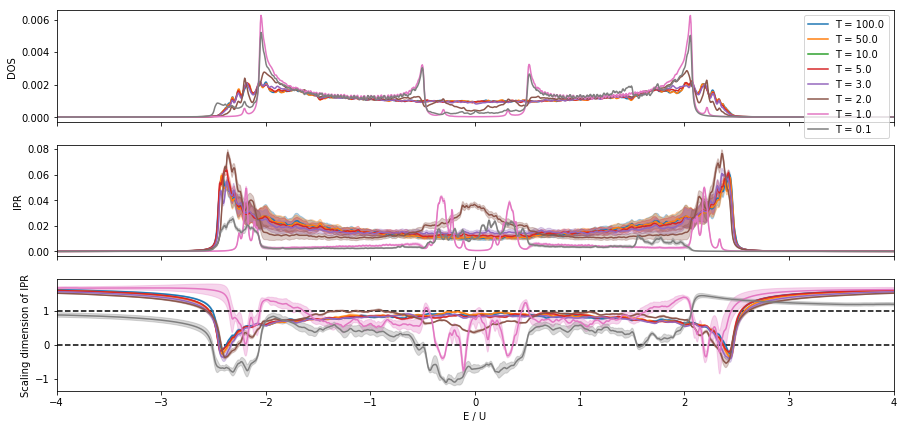

In [404]:
def plot_Ts(o, N_i = -1, spread_IPR = True):
    print(" ".join(f'{k}={v}' for k,v in o.parameters.items() if k != 'J_matrix'))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, axes = plt.subplots(3,1, figsize = (15,7), sharex = 'col')
    
    for T_i, T in zip(count(), o.Ts):
        try:
            m, c, dm, dc = scaling_dimension(o.Ns, o.IPR[:, T_i], o.dIPR[:, T_i], use_true_errors = True)
            scaling_fit = True
        except:
            scaling_fit = False



        i = N_i
        N = o.Ns[N_i]
        axes[0].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.DOS[i, T_i], label = f'T = {T}', color = colors[T_i])
        if spread_IPR:
            spread(axes[1], o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], o.dIPR[i, T_i], color = colors[T_i])
        else:    
            axes[1].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], color = colors[T_i])

        if scaling_fit: spread(axes[2], o.energy_histogram_bins[1:] / o.parameters.U, -m, dm, color = colors[T_i])


    axes[2].set(ylabel = 'Scaling dimension of IPR', xlim = (-1,1), xlabel = 'E / U')

    axes[0].set(ylabel = 'DOS')    
    axes[1].set(ylabel = 'IPR', xlim = (-4,4), xlabel = 'E / U')

    xlim = axes[2].get_xlim()
    axes[2].hlines([0,1], xmin = xlim[0], xmax = xlim[1], linestyles = 'dashed')

    axes[0].legend();
    
    
T_i = 2
T = oHighT.Ts[T_i]
print(f'T = {T}, T_i = {T_i}')
plot_Ts(oHighT, N_i = -1)

T = 10, T_i = 2
t=1 alpha=1.25 mu=0 beta=Variable J=5 U=1 normalise=True


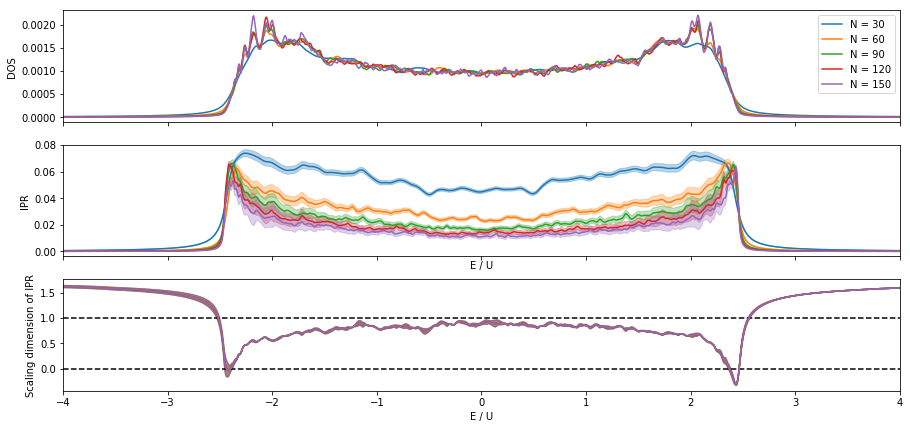

In [389]:
def plot_scaling_dimension(o, T_i, spread_IPR = True):
    print(" ".join(f'{k}={v}' for k,v in o.parameters.items() if k != 'J_matrix'))
    try:
        m, c, dm, dc = scaling_dimension(o.Ns, o.IPR[:, T_i], o.dIPR[:, T_i], use_true_errors = True)
        scaling_fit = True
    except:
        scaling_fit = False

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, axes = plt.subplots(3,1, figsize = (15,7), sharex = 'col')

    for i,N in zip(count(), o.Ns):
        axes[0].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.DOS[i, T_i], label = f'N = {N}', color = colors[i])
        if spread_IPR:
            spread(axes[1], o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], o.dIPR[i, T_i], color = colors[i])
        else:    
            axes[1].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], color = colors[i])

        if scaling_fit: spread(axes[2], o.energy_histogram_bins[1:] / o.parameters.U, -m, dm, color = colors[i])


    axes[2].set(ylabel = 'Scaling dimension of IPR', xlim = (-1,1), xlabel = 'E / U')

    axes[0].set(ylabel = 'DOS')    
    axes[1].set(ylabel = 'IPR', xlim = (-4,4), xlabel = 'E / U')

    xlim = axes[2].get_xlim()
    axes[2].hlines([0,1], xmin = xlim[0], xmax = xlim[1], linestyles = 'dashed')

    axes[0].legend();
    
    
T_i = 2
T = oHighT.Ts[T_i]
print(f'T = {T}, T_i = {T_i}')
plot_scaling_dimension(oHighT, T_i)

In [359]:
print(f'Computing the infT limit for Ns = {oHighT.Ns}')
oinfT = Munch()
o = oinfT
o.N_eigenstates = int(1e5) # do states / N disorder realisations
o.Ns = oHighT.Ns# system sizes
o.Ts = np.array([np.infty,])

o.t = 1
o.U = 1
o.J = 5
o.spread_IPR = False

o.energy_histogram_bins = np.linspace(-3*o.U, 3*o.U, 1000 + 1)
shape = (4, len(o.Ns), 1, len(o.energy_histogram_bins)-1)
o.DOS, o.IPR, o.dDOS, o.dIPR = np.nan * np.zeros(shape = shape)

for i,N in zip(count(), o.Ns):
    M = o.N_eigenstates // N + 1 # Number of Disorder_realisations
    states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    o.parameters = Munch(mu=0.0, beta = np.nan, U = o.U, t = o.t, N = N, alpha = 1.25, J = o.J)
    o.DOS[i], o.IPR[i], o.dDOS[i], o.dIPR[i] = solve(states, o.parameters, scale = 0.5, energy_histogram_bins = o.energy_histogram_bins)
    
    

Computing the infT limit for Ns = [ 30  60  90 120 150]


T = inf, T_i = 0
mu=0.0 beta=nan U=1 t=1 N=150 alpha=1.25 J=5


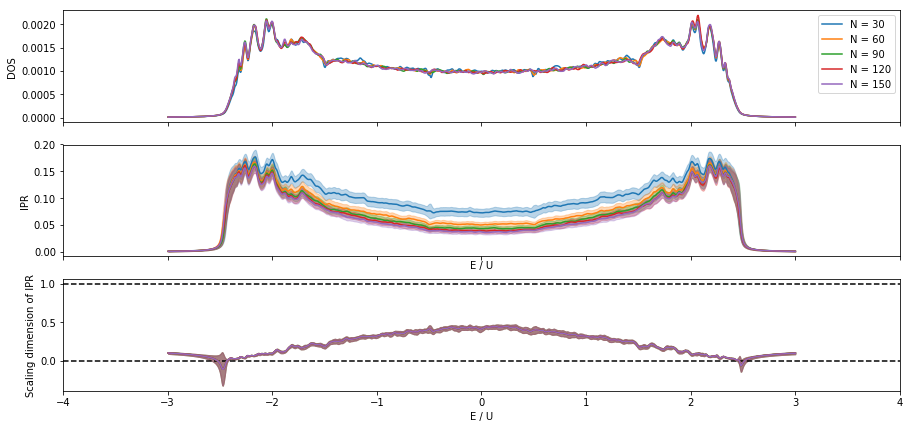

In [360]:
T_i = 0
T = o.Ts[T_i]
print(f'T = {T}, T_i = {T_i}')
plot_scaling_dimension(oinfT, T_i)

In [1]:
def compare_DOS_IPR(os, T_is, spread_IPR = True):
    Ns = os[0].Ns
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, axes = plt.subplots(len(Ns),2, figsize = (15,7), sharex = 'col')

    for i,N in zip(count(), Ns):
        for j,o,T_i in zip(count(),os, T_is):
            axes[i, 0].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.DOS[i, T_i], label = f'T = {o.Ts[T_i]}', color = colors[j])
        
            if spread_IPR:
                spread(axes[i, 1], o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], o.dIPR[i, T_i], color = colors[j])
            else:    
                axes[i, 1].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], color = colors[j])

        
        axes[i, 0].legend()
        
        #if spread_IPR:
        #    spread(axes[1], o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], o.dIPR[i, T_i], color = colors[i])
        #else:    
        #    axes[1].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.IPR[i, T_i], color = colors[i])

        #spread(axes[2], o.energy_histogram_bins[1:] / o.parameters.U, -m, dm, color = colors[i])


    #axes[2].set(ylabel = 'Scaling dimension of IPR', xlim = (-1,1), xlabel = 'E / U')

    #axes[0].set(ylabel = 'DOS')    
    #axes[1].set(ylabel = 'IPR', xlim = (-4,4), xlabel = 'E / U')

    #xlim = axes[2].get_xlim()
    #axes[2].hlines([0,1], xmin = xlim[0], xmax = xlim[1], linestyles = 'dashed')

    #axes[0].legend();
    
from itertools import chain, repeat    
T_is = [0,0,1,2,3,4,5,6,7]
data_sources =  list(chain([oinfT,], repeat(oHighT)))[:len(T_is)]
              
compare_DOS_IPR(os = data_sources, 
                T_is = T_is,
                spread_IPR = True)

NameError: name 'oinfT' is not defined

In [411]:
help(chain)

Help on class chain in module itertools:

class chain(builtins.object)
 |  chain(*iterables) --> chain object
 |  
 |  Return a chain object whose .__next__() method returns elements from the
 |  first iterable until it is exhausted, then elements from the next
 |  iterable, until all of the iterables are exhausted.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  __setstate__(...)
 |      Set state information for unpickling.
 |  
 |  from_iterable(...) from builtins.type
 |      chain.from_iterable(iterable) --> chain object
 |      
 |      Alternate chain() constructor taking a single iterable argument